# Creating your own data set pipeline for neural network training in Pytorch

Source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

torch.utils.data.Dataset    
    a. \__len__    
    b. \__getitem__    

torch.utils.data.DataLoader

In [22]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader  # Will be used to inherit some attributes
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [23]:
# Read a sample image and a landmark label
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))


Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


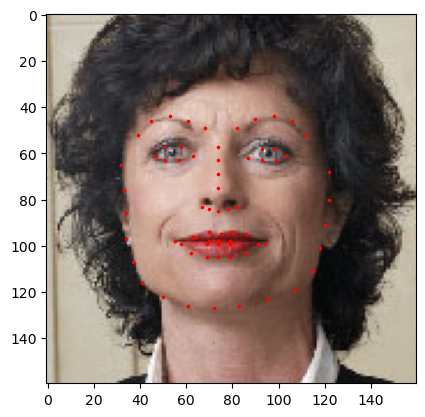

In [24]:
# Helper Function to display image and the landmark points overlayed
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

## Build a Data Pipeline
1. We will create a Dataset Class for the face-landmark data.  
2. Our dataset class will take path to csv file, path to images(root_dir of data), and  another option 'transform' that can do some pre-processing in the data or augument the data. 
3. Our data will be a dictionary {'image': image, 'landmarks': landmarks}.     
4. We will inherit Dataset from torch.utils.data.Dataset to use followings:    
    a. \__len__ so that len(dataset) returns the size of the dataset.     
                    
    b. \__getitem__ to support the indexing such that dataset[i] can be used to get 
ith sample. 

    We will modify \__getitem__ to fit our case

In [25]:
class FaceLandmarksDataset(Dataset): # Note we are inheriting torch data util Dataset
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() # __getitem__ needs idx to be list type

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name) # Element in first column is image name
        landmarks = self.landmarks_frame.iloc[idx, 1:] # All other elements in column are landmarks
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2) # convert into (x,y) coordinates
        sample = {'image': image, 'landmarks': landmarks} # Finally creates a data sample

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)


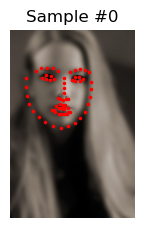

1 (500, 333, 3) (68, 2)


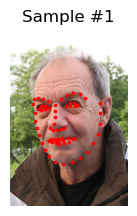

2 (250, 258, 3) (68, 2)


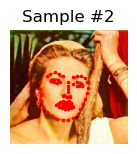

3 (434, 290, 3) (68, 2)


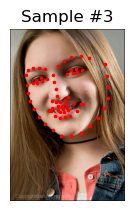

In [26]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

1. We can now use torch data utilities torch.utils.data.random_splitto create train validation and test data. 
2. Then use torch dataloader similarly as in 01ANN.ipynb example to take care of batch, shuffling
 

In [21]:
train_set, test_set, val_set = torch.utils.data.random_split(face_dataset, [.6, .2, .2])
